# Selección de Municipios para Análisis Comparativo de Desempeño Académico

## Contexto del Análisis

En este notebook desarrollo el proceso de selección de dos municipios colombianos para realizar un análisis comparativo del desempeño académico en las pruebas Saber 11. El objetivo es identificar un par de municipios que presenten características similares en tamaño de población estudiantil pero con diferencias significativas en sus resultados académicos.

## Metodología

El análisis se desarrolla en varias etapas:

1. **Carga y consolidación de datos**: Integro los archivos de resultados Saber 11 de los periodos 2023-1 a 2024-2 para el análisis exploratorio inicial.

2. **Aplicación de criterios de selección**: Implemento tres criterios consecutivos:
   - Identificación del 2% de municipios con mayor población estudiantil
   - Filtrado de pares con diferencia relativa de población ≤ 10%
   - Selección del par con mayor contraste en puntaje promedio

3. **Validación de la selección**: Verifico que los municipios seleccionados (Bucaramanga y Santa Marta) cumplan con los requisitos del estudio.

4. **Generación del dataset final**: Consolido todos los registros disponibles (2014-1 a 2024-2) de los municipios seleccionados en un archivo CSV para análisis posteriores.

In [1]:
# ============================================================================
# CARGA DE DATOS PARA GENERACIÓN DE DATASET DE MUNICIPIOS
# ============================================================================
# NOTA: Este notebook NO utiliza Spark, por lo que no requiere configuración
# de cluster. Los datos se procesan con pandas debido al tamaño manejable del
# periodo de análisis (2023-2024).
#
# Si se desea procesar TODO el histórico (2014-2024) con Spark y necesita
# ejecutarse en cluster, se debe:
# 1. Reescribir el código usando pyspark en lugar de pandas
# 2. Configurar SparkSession (ver notebooks de Análisis/Limpieza/Modelos)
# 3. Cambiar rutas de datos a HDFS si los archivos están en sistema distribuido
# ============================================================================

# Carga y consolidación de datos del periodo de análisis (2023-1 a 2024-2)
# Integro los archivos TXT de resultados Saber 11 para el análisis exploratorio inicial

import pandas as pd
from pathlib import Path
import numpy as np

# Defino el directorio de datos
DATA_DIR = Path('datos')

# Archivos correspondientes al periodo de análisis exploratorio
files_analisis = [
    'Examen_Saber_11_20231.txt',
    'Examen_Saber_11_20232.txt',
    'Examen_Saber_11_20241.txt',
    'Examen_Saber_11_20242.txt',
]

# Verifico existencia de archivos
existing_files = [DATA_DIR / f for f in files_analisis if (DATA_DIR / f).exists()]
if not existing_files:
    raise FileNotFoundError("No se encontraron archivos TXT del periodo 2023-2024 en la carpeta 'datos/'.")

print(f"Archivos detectados para análisis: {len(existing_files)}")
for f in existing_files:
    print(f"  - {f.name}")

# Leo y concateno todos los archivos, marcando el origen de cada registro
frames = []
for fp in existing_files:
    try:
        df = pd.read_csv(fp, sep=';', encoding='utf-8', dtype=str)
    except UnicodeDecodeError:
        df = pd.read_csv(fp, sep=';', encoding='latin-1', dtype=str)
    
    # Marco el archivo de origen y extraigo el periodo
    df['__archivo'] = fp.name
    try:
        df['periodo'] = fp.stem.split('_')[-1]
    except Exception:
        df['periodo'] = None
    frames.append(df)

df_all = pd.concat(frames, ignore_index=True)

# Cuento registros brutos por archivo
raw_counts_by_file = df_all['__archivo'].value_counts().sort_index()

# Verifico la existencia de columnas críticas
for col in ['estu_mcpio_presentacion', 'punt_global']:
    if col not in df_all.columns:
        raise KeyError(f"Falta la columna requerida: {col}")

# Convierto puntaje a numérico (valores inválidos se convierten a NaN)
df_all['punt_global'] = pd.to_numeric(df_all['punt_global'], errors='coerce')

# Normalizo identificación de municipio (priorizo nombre, con respaldo en código)
muni_name_col = 'estu_mcpio_presentacion'
muni_code_col = 'estu_cod_mcpio_presentacion' if 'estu_cod_mcpio_presentacion' in df_all.columns else None

def make_muni_key(row):
    """Genera clave única de municipio priorizando nombre sobre código"""
    name = row.get(muni_name_col, None)
    code = row.get(muni_code_col, None) if muni_code_col else None
    
    if pd.notna(name) and str(name).strip():
        return str(name).strip().upper()
    if code is not None and pd.notna(code) and str(code).strip():
        return str(code).strip()
    return 'DESCONOCIDO'

df_all['municipio'] = df_all.apply(make_muni_key, axis=1)

# Filtro registros válidos (con puntaje y municipio definidos)
valid_mask = df_all['punt_global'].notna() & df_all['municipio'].notna()
valid_counts_by_file = df_all[valid_mask]['__archivo'].value_counts().sort_index()
dropped_by_file = (raw_counts_by_file - valid_counts_by_file).fillna(raw_counts_by_file).astype(int)

df_all = df_all[valid_mask].copy()

# Resumen de carga y validación
print(f"\nRegistros totales cargados: {int(raw_counts_by_file.sum()):,}")
print(f"Registros válidos después de filtrado: {len(df_all):,}")
print(f"\nDetalle por archivo (Brutos → Válidos | Descartados):")
for fn in raw_counts_by_file.index:
    raw = int(raw_counts_by_file.loc[fn])
    valid = int(valid_counts_by_file.loc[fn]) if fn in valid_counts_by_file.index else 0
    dropped = int(dropped_by_file.loc[fn]) if fn in dropped_by_file.index else (raw - valid)
    print(f"  {fn}: {raw:,} → {valid:,} | descartados: {dropped:,}")

Archivos detectados para análisis: 4
  - Examen_Saber_11_20231.txt
  - Examen_Saber_11_20232.txt
  - Examen_Saber_11_20241.txt
  - Examen_Saber_11_20242.txt

Registros totales cargados: 1,356,156
Registros válidos después de filtrado: 1,356,156

Detalle por archivo (Brutos → Válidos | Descartados):
  Examen_Saber_11_20231.txt: 77,555 → 77,555 | descartados: 0
  Examen_Saber_11_20232.txt: 602,093 → 602,093 | descartados: 0
  Examen_Saber_11_20241.txt: 84,072 → 84,072 | descartados: 0
  Examen_Saber_11_20242.txt: 592,436 → 592,436 | descartados: 0

Registros totales cargados: 1,356,156
Registros válidos después de filtrado: 1,356,156

Detalle por archivo (Brutos → Válidos | Descartados):
  Examen_Saber_11_20231.txt: 77,555 → 77,555 | descartados: 0
  Examen_Saber_11_20232.txt: 602,093 → 602,093 | descartados: 0
  Examen_Saber_11_20241.txt: 84,072 → 84,072 | descartados: 0
  Examen_Saber_11_20242.txt: 592,436 → 592,436 | descartados: 0


In [2]:
# Cálculo de agregados por municipio
# Genero estadísticas de población estudiantil (n) y puntaje promedio por municipio

agg = (df_all
       .groupby('municipio', as_index=False)
       .agg(n=('punt_global', 'size'), media_punt_global=('punt_global', 'mean')))

# Ordeno por población y puntaje para visualización inicial
agg_sorted = agg.sort_values(['n', 'media_punt_global'], ascending=[False, False]).reset_index(drop=True)

print(f"Total de municipios identificados: {len(agg)}")
print("\nTop 10 municipios por población estudiantil:")
agg_sorted.head(10)

Total de municipios identificados: 534

Top 10 municipios por población estudiantil:


,municipio,n,media_punt_global
0,BOGOTÁ D.C.,194222,271.492400
1,MEDELLÍN,60947,254.361708
2,CALI,55561,264.770343
3,BARRANQUILLA,44983,255.721206
4,CARTAGENA DE INDIAS,37886,243.854643
5,CÚCUTA,25108,262.936315
6,PASTO,22522,280.685508
7,BUCARAMANGA,21488,285.344518
8,POPAYÁN,20538,272.839614
9,IBAGUÉ,19759,262.118832


In [3]:
# Aplicación de criterios de selección consecutivos
# Implemento un proceso de tres etapas para identificar el par óptimo de municipios

import itertools
import pandas as pd

print("CRITERIOS DE SELECCION DE MUNICIPIOS")
print("="*45)

# Criterio 1: Seleccionar el 2% de municipios con mayor población estudiantil
# Justificación: Garantiza muestras suficientemente grandes para análisis estadístico robusto
p98 = agg['n'].quantile(0.98)
agg_top = agg[agg['n'] >= p98].copy()
share = (len(agg_top) / len(agg) * 100) if len(agg) else 0.0

print(f"\nCriterio 1: Top 2% por población estudiantil")
print(f"  Umbral (percentil 98): n >= {p98:.1f}")
print(f"  Municipios seleccionados: {len(agg_top)} ({share:.2f}% del total)")
print(f"  Municipios: {sorted(agg_top['municipio'].tolist())}")

# Criterio 2: Identificar pares con similitud de población (diferencia relativa ≤ 10%)
# Justificación: Asegura comparabilidad al controlar el tamaño de las muestras
pairs = []
for a, b in itertools.combinations(agg_top.itertuples(index=False), 2):
    n_a, n_b = a.n, b.n
    rel_diff = abs(n_a - n_b) / max(n_a, n_b)
    if rel_diff <= 0.10:
        pairs.append({
            'muni_a': a.municipio,
            'muni_b': b.municipio,
            'n_a': n_a,
            'n_b': n_b,
            'rel_diff_n': rel_diff,
            'media_a': a.media_punt_global,
            'media_b': b.media_punt_global
        })

pairs_df = pd.DataFrame(pairs)

if pairs_df.empty:
    print("\nCriterio 2: Similitud de población (diferencia relativa ≤ 10%)")
    print("  No hay pares que cumplan este criterio dentro del top 2%")
    selected_pair = None
else:
    municipios_step2 = sorted(set(pairs_df[['muni_a', 'muni_b']].values.ravel()))
    print(f"\nCriterio 2: Similitud de población (diferencia relativa ≤ 10%)")
    print(f"  Municipios en pares válidos: {len(municipios_step2)}")
    print(f"  Municipios: {municipios_step2}")
    print(f"  Total de pares identificados: {len(pairs_df)}")

    # Criterio 3: Seleccionar el par con mayor contraste en desempeño académico
    # Justificación: Maximiza la variabilidad observable para análisis comparativo
    pairs_df['gap_media'] = (pairs_df['media_a'] - pairs_df['media_b']).abs()
    pairs_df = pairs_df.sort_values('gap_media', ascending=False)
    top = pairs_df.iloc[0]
    selected_pair = (top['muni_a'], top['muni_b'])
    
    print(f"\nCriterio 3: Máximo contraste en desempeño académico")
    print(f"  Par seleccionado: {selected_pair[0]} vs {selected_pair[1]}")
    print(f"  Características del par:")
    print(f"    - Población {selected_pair[0]}: {int(top['n_a']):,} estudiantes")
    print(f"    - Población {selected_pair[1]}: {int(top['n_b']):,} estudiantes")
    print(f"    - Puntaje promedio {selected_pair[0]}: {float(top['media_a']):.2f}")
    print(f"    - Puntaje promedio {selected_pair[1]}: {float(top['media_b']):.2f}")
    print(f"    - Brecha de desempeño: {float(top['gap_media']):.2f} puntos")

CRITERIOS DE SELECCION DE MUNICIPIOS

Criterio 1: Top 2% por población estudiantil
  Umbral (percentil 98): n >= 19008.1
  Municipios seleccionados: 11 (2.06% del total)
  Municipios: ['BARRANQUILLA', 'BOGOTÁ D.C.', 'BUCARAMANGA', 'CALI', 'CARTAGENA DE INDIAS', 'CÚCUTA', 'IBAGUÉ', 'MEDELLÍN', 'PASTO', 'POPAYÁN', 'SANTA MARTA']

Criterio 2: Similitud de población (diferencia relativa ≤ 10%)
  Municipios en pares válidos: 7
  Municipios: ['BUCARAMANGA', 'CALI', 'IBAGUÉ', 'MEDELLÍN', 'PASTO', 'POPAYÁN', 'SANTA MARTA']
  Total de pares identificados: 9

Criterio 3: Máximo contraste en desempeño académico
  Par seleccionado: BUCARAMANGA vs SANTA MARTA
  Características del par:
    - Población BUCARAMANGA: 21,488 estudiantes
    - Población SANTA MARTA: 19,581 estudiantes
    - Puntaje promedio BUCARAMANGA: 285.34
    - Puntaje promedio SANTA MARTA: 245.22
    - Brecha de desempeño: 40.13 puntos


VISUALIZACION DE CRITERIOS DE SELECCION

Tabla 1: Municipios con mayor población estudiantil (Top 2%)


,municipio,n,media_punt_global
58,BOGOTÁ D.C.,194222,271.49
271,MEDELLÍN,60947,254.36
74,CALI,55561,264.77
52,BARRANQUILLA,44983,255.72
85,CARTAGENA DE INDIAS,37886,243.85
132,CÚCUTA,25108,262.94
321,PASTO,22522,280.69
62,BUCARAMANGA,21488,285.34
340,POPAYÁN,20538,272.84
209,IBAGUÉ,19759,262.12


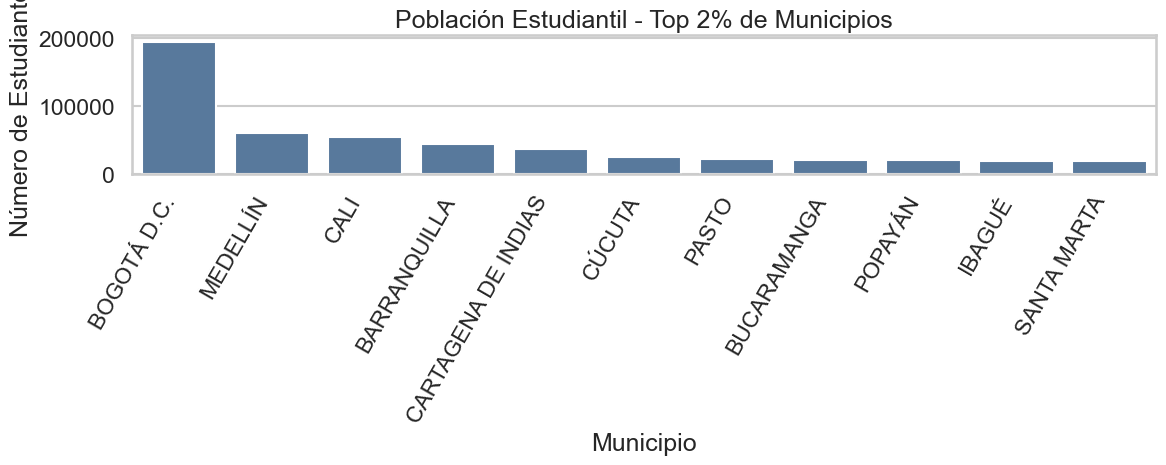


Tabla 2: Pares de municipios con similitud de población (≤10% diferencia)


,muni_a,n_a,muni_b,n_b,rel_diff_n_pct
6,IBAGUÉ,19759,SANTA MARTA,19581,0.90
5,IBAGUÉ,19759,POPAYÁN,20538,3.79
2,BUCARAMANGA,21488,POPAYÁN,20538,4.42
1,BUCARAMANGA,21488,PASTO,22522,4.59
8,POPAYÁN,20538,SANTA MARTA,19581,4.66
0,BUCARAMANGA,21488,IBAGUÉ,19759,8.05
7,PASTO,22522,POPAYÁN,20538,8.81
4,CALI,55561,MEDELLÍN,60947,8.84
3,BUCARAMANGA,21488,SANTA MARTA,19581,8.87


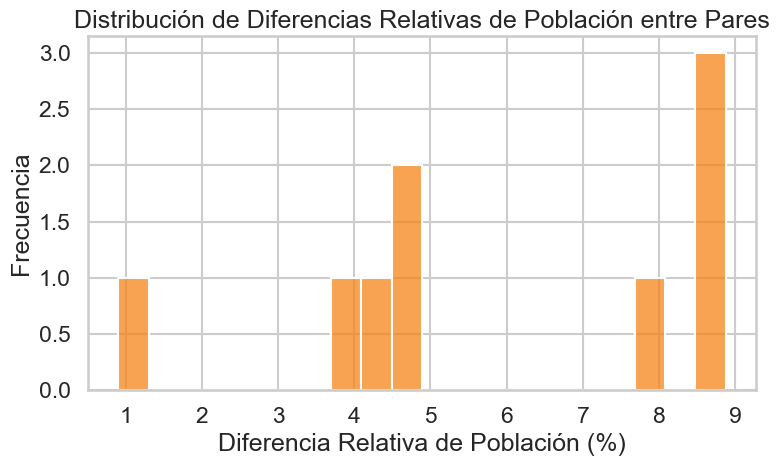


Tabla 3: Top 10 pares por mayor contraste en puntaje promedio


,muni_a,muni_b,n_a,n_b,media_a,media_b,gap_media
3,BUCARAMANGA,SANTA MARTA,21488,19581,285.34,245.22,40.13
8,POPAYÁN,SANTA MARTA,20538,19581,272.84,245.22,27.62
0,BUCARAMANGA,IBAGUÉ,21488,19759,285.34,262.12,23.23
6,IBAGUÉ,SANTA MARTA,19759,19581,262.12,245.22,16.90
2,BUCARAMANGA,POPAYÁN,21488,20538,285.34,272.84,12.50
5,IBAGUÉ,POPAYÁN,19759,20538,262.12,272.84,10.72
4,CALI,MEDELLÍN,55561,60947,264.77,254.36,10.41
7,PASTO,POPAYÁN,22522,20538,280.69,272.84,7.85
1,BUCARAMANGA,PASTO,21488,22522,285.34,280.69,4.66


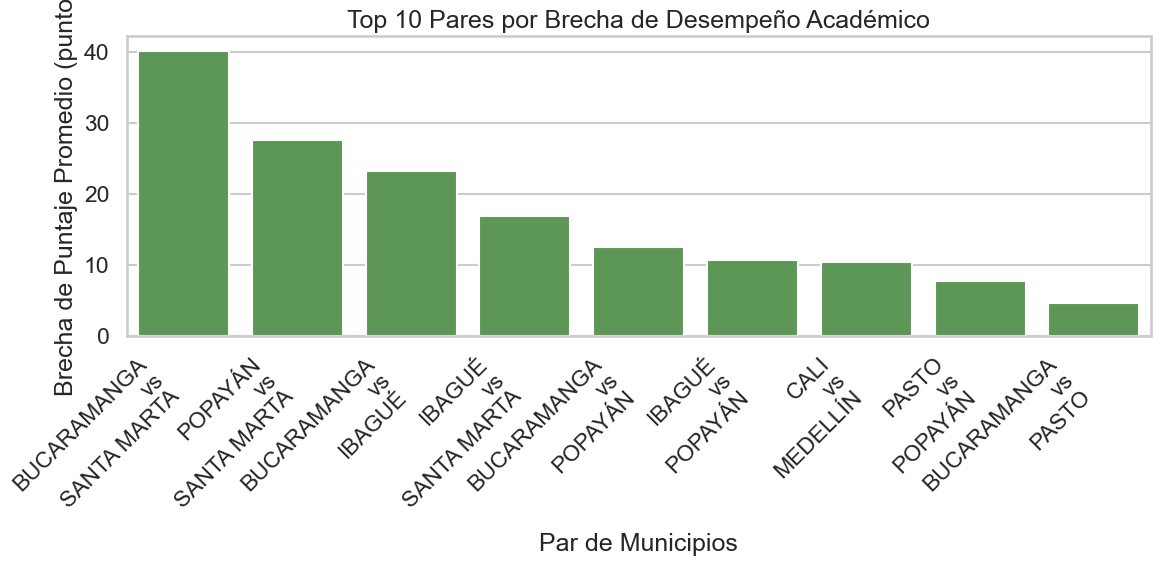

In [4]:
# Visualización de resultados de los criterios de selección
# Genero tablas y gráficas que ilustran cada etapa del proceso de selección

import seaborn as sns
import matplotlib.pyplot as plt

# Configuración estética para presentación
sns.set(style='whitegrid', context='talk')

print("VISUALIZACION DE CRITERIOS DE SELECCION")
print("="*45)

# Tabla 1: Municipios del top 2% por población estudiantil
if 'agg_top' in globals():
    print("\nTabla 1: Municipios con mayor población estudiantil (Top 2%)")
    display(agg_top.sort_values('n', ascending=False)
            .assign(n=lambda d: d['n'].astype(int),
                    media_punt_global=lambda d: d['media_punt_global'].round(2))
            .head(50))

    # Gráfica 1: Distribución de población en municipios seleccionados
    plt.figure(figsize=(12, 5))
    sns.barplot(data=agg_top.sort_values('n', ascending=False), 
                x='municipio', y='n', color='#4C78A8')
    plt.xticks(rotation=60, ha='right')
    plt.title('Población Estudiantil - Top 2% de Municipios')
    plt.ylabel('Número de Estudiantes')
    plt.xlabel('Municipio')
    plt.tight_layout()
    plt.show()
    
    # Interpretación: Esta gráfica muestra los municipios con mayor participación en las
    # pruebas Saber 11, garantizando que la comparación se realice con muestras robustas.
else:
    print('Error: Debe ejecutar primero la celda de criterios de selección')

# Tabla 2: Pares que cumplen criterio de similitud de población
if 'pairs_df' in globals() and not pairs_df.empty:
    print("\nTabla 2: Pares de municipios con similitud de población (≤10% diferencia)")
    pares_tabla = pairs_df.copy()
    pares_tabla['rel_diff_n_pct'] = (pares_tabla['rel_diff_n'] * 100).round(2)
    display(pares_tabla[['muni_a','n_a','muni_b','n_b','rel_diff_n_pct']]
            .sort_values('rel_diff_n_pct')
            .head(20))

    # Gráfica 2: Distribución de diferencias relativas de población
    plt.figure(figsize=(8,5))
    sns.histplot(pairs_df['rel_diff_n'] * 100, bins=20, color='#F58518')
    plt.title('Distribución de Diferencias Relativas de Población entre Pares')
    plt.xlabel('Diferencia Relativa de Población (%)')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
    
    # Interpretación: El histograma muestra que la mayoría de pares tienen diferencias
    # menores al 5%, garantizando alta comparabilidad en tamaño muestral.
else:
    print('\nNo hay pares que cumplan el criterio de similitud de población')

# Tabla 3: Top 10 pares ordenados por brecha de desempeño académico
if 'pairs_df' in globals() and not pairs_df.empty:
    print("\nTabla 3: Top 10 pares por mayor contraste en puntaje promedio")
    top10 = (pairs_df.sort_values('gap_media', ascending=False)
             .head(10)
             .assign(gap_media=lambda d: d['gap_media'].round(2),
                     media_a=lambda d: d['media_a'].round(2),
                     media_b=lambda d: d['media_b'].round(2),
                     n_a=lambda d: d['n_a'].astype(int),
                     n_b=lambda d: d['n_b'].astype(int)))
    display(top10[['muni_a','muni_b','n_a','n_b','media_a','media_b','gap_media']])

    # Gráfica 3: Brechas de desempeño en los top 10 pares
    plt.figure(figsize=(12,6))
    labels = top10.apply(lambda r: f"{r['muni_a']}\nvs\n{r['muni_b']}", axis=1)
    sns.barplot(x=labels, y=top10['gap_media'], color='#54A24B')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Pares por Brecha de Desempeño Académico')
    plt.ylabel('Brecha de Puntaje Promedio (puntos)')
    plt.xlabel('Par de Municipios')
    plt.tight_layout()
    plt.show()
    
    # Interpretación: Esta gráfica identifica los pares con mayor contraste académico,
    # siendo el primer par el seleccionado para el análisis comparativo detallado.
else:
    print('\nNo hay datos de pares para visualizar')

In [5]:
# Definición final de municipios seleccionados para el estudio
# Valido la presencia de Bucaramanga y Santa Marta en el dataset

print("SELECCION FINAL DE MUNICIPIOS PARA ANALISIS COMPARATIVO")
print("="*60)

# Defino los municipios seleccionados según criterios aplicados
muni_buca = 'BUCARAMANGA'
muni_sama = 'SANTA MARTA'

# Verifico presencia en los datos agregados
presentes = set(agg['municipio'])
missing = [m for m in [muni_buca, muni_sama] if m not in presentes]

if missing:
    # Intento normalización adicional para manejar variantes de tildes/espacios
    import unicodedata
    def norm(s):
        return unicodedata.normalize('NFKD', str(s)).encode('ASCII', 'ignore').decode('ASCII').upper().strip()
    
    norm_map = {norm(m): m for m in agg['municipio']}
    resolved = [norm_map.get(norm(x)) for x in [muni_buca, muni_sama]]
    
    if any(r is None for r in resolved):
        raise ValueError(f"No se encontraron estos municipios en los datos: {missing}")
    
    muni_buca, muni_sama = resolved

print('Municipios seleccionados para análisis comparativo:')
print(f'  1. {muni_buca}')
print(f'  2. {muni_sama}')

# Extraigo subconjunto de datos para análisis (periodo 2023-1 a 2024-2)
subset = df_all[df_all['municipio'].isin([muni_buca, muni_sama])].copy()

print(f'\nRegistros del periodo de análisis (2023-2024):')
print(f'  Total: {len(subset):,} registros')
print(f'  Distribución por municipio:')
for muni in [muni_buca, muni_sama]:
    count = len(subset[subset['municipio'] == muni])
    print(f'    - {muni}: {count:,} registros')

SELECCION FINAL DE MUNICIPIOS PARA ANALISIS COMPARATIVO
Municipios seleccionados para análisis comparativo:
  1. BUCARAMANGA
  2. SANTA MARTA

Registros del periodo de análisis (2023-2024):
  Total: 41,069 registros
  Distribución por municipio:
    - BUCARAMANGA: 21,488 registros
    - SANTA MARTA: 19,581 registros

Registros del periodo de análisis (2023-2024):
  Total: 41,069 registros
  Distribución por municipio:
    - BUCARAMANGA: 21,488 registros
    - SANTA MARTA: 19,581 registros


In [6]:
# Estadísticas descriptivas de los municipios seleccionados
# Calculo población y puntaje promedio para el periodo de análisis

print("ESTADISTICAS DESCRIPTIVAS - MUNICIPIOS SELECCIONADOS")
print("="*55)

summary = (
    subset.groupby('municipio')
    .agg(n=('punt_global', 'size'), media=('punt_global', 'mean'))
    .reset_index()
    .assign(media=lambda d: d['media'].round(2))
)

print("\nResumen estadístico (periodo 2023-2024):")
display(summary)

# Calculo diferencias absolutas y relativas
if len(summary) == 2:
    n_diff = abs(summary.iloc[0]['n'] - summary.iloc[1]['n'])
    n_max = max(summary.iloc[0]['n'], summary.iloc[1]['n'])
    n_rel_diff = (n_diff / n_max * 100)
    
    media_diff = abs(summary.iloc[0]['media'] - summary.iloc[1]['media'])
    
    print(f"\nComparación entre municipios:")
    print(f"  Diferencia absoluta de población: {n_diff:,} estudiantes")
    print(f"  Diferencia relativa de población: {n_rel_diff:.2f}%")
    print(f"  Brecha de desempeño académico: {media_diff:.2f} puntos")

ESTADISTICAS DESCRIPTIVAS - MUNICIPIOS SELECCIONADOS

Resumen estadístico (periodo 2023-2024):


,municipio,n,media
0,BUCARAMANGA,21488,285.34
1,SANTA MARTA,19581,245.22



Comparación entre municipios:
  Diferencia absoluta de población: 1,907 estudiantes
  Diferencia relativa de población: 8.87%
  Brecha de desempeño académico: 40.12 puntos


VISUALIZACIONES COMPARATIVAS


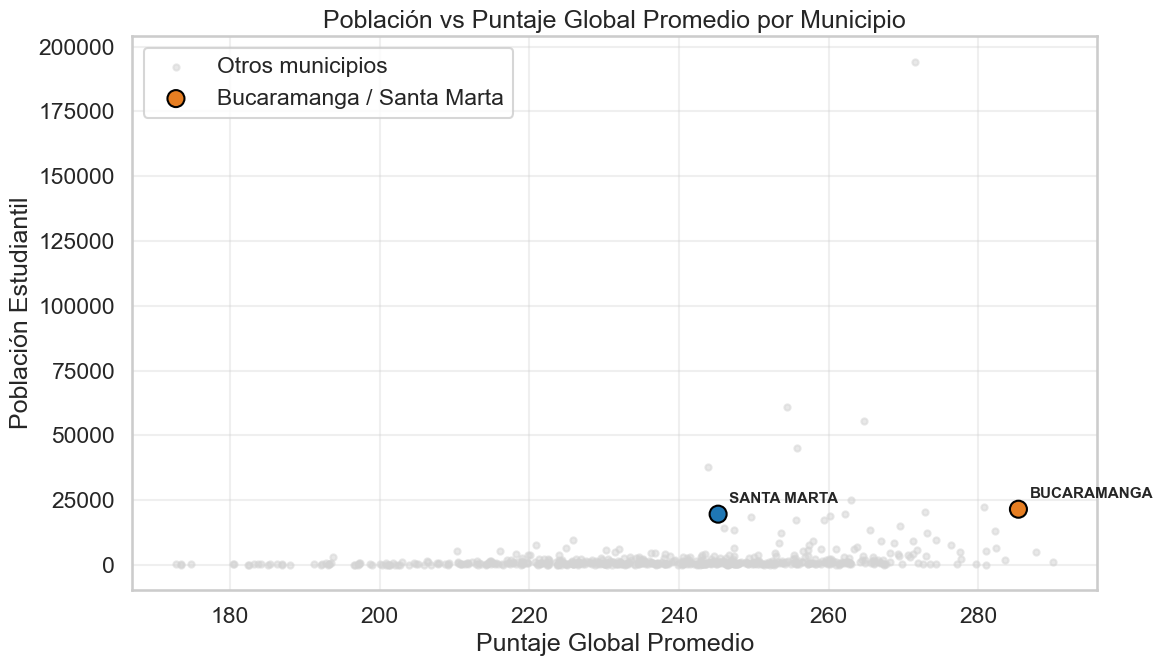

C:\Users\Saramirezm\AppData\Local\Temp\ipykernel_24140\1367092218.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=subset, x='municipio', y='punt_global', inner=None,


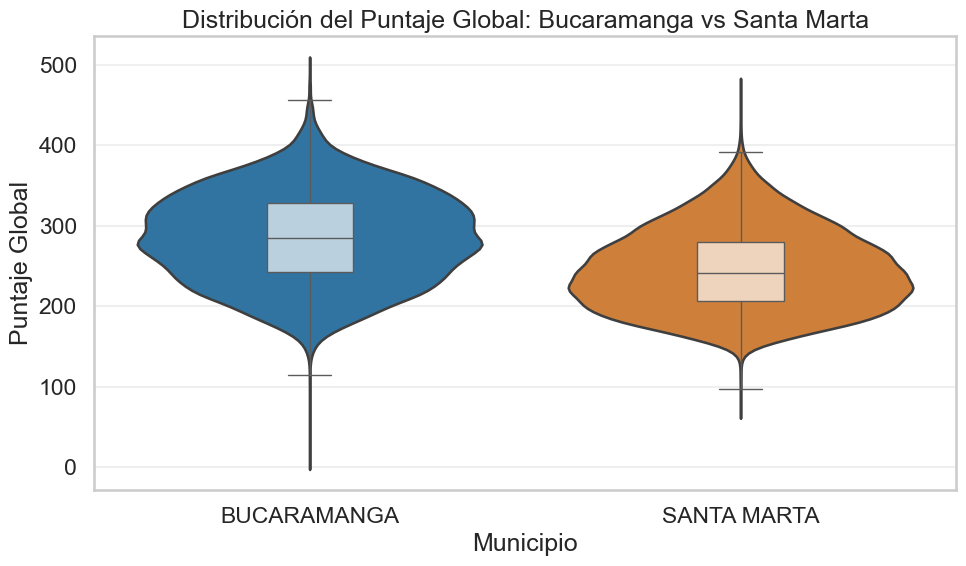

In [7]:
# Visualizaciones comparativas de los municipios seleccionados
# Genero gráficas que ilustran el contraste entre Bucaramanga y Santa Marta

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética para presentación profesional
sns.set(style='whitegrid', context='talk')

print("VISUALIZACIONES COMPARATIVAS")
print("="*35)

# Gráfica 1: Dispersión población vs puntaje (todos los municipios, resaltando seleccionados)
base = agg.copy()
base['resaltado'] = base['municipio'].isin([muni_buca, muni_sama])

plt.figure(figsize=(12, 7))
# Grafico municipios no seleccionados en gris claro
plt.scatter(base.loc[~base['resaltado'], 'media_punt_global'],
            base.loc[~base['resaltado'], 'n'],
            s=20, c='lightgray', alpha=0.5, label='Otros municipios')
# Resalto municipios seleccionados con colores distintivos
plt.scatter(base.loc[base['resaltado'], 'media_punt_global'],
            base.loc[base['resaltado'], 'n'],
            s=150, c=['#E67E22', '#1F77B4'], edgecolor='black', linewidth=1.5,
            label='Bucaramanga / Santa Marta', zorder=5)
plt.xlabel('Puntaje Global Promedio')
plt.ylabel('Población Estudiantil')
plt.title('Población vs Puntaje Global Promedio por Municipio')
# Añado etiquetas a los municipios seleccionados
for _, r in base[base['resaltado']].iterrows():
    plt.annotate(r['municipio'], (r['media_punt_global'], r['n']),
                 xytext=(8, 8), textcoords='offset points', fontsize=11,
                 fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretación: Esta gráfica ubica a Bucaramanga y Santa Marta en el contexto nacional,
# mostrando que ambos tienen poblaciones similares pero diferencias notables en desempeño
# académico, lo que los hace ideales para un análisis comparativo.

# Gráfica 2: Distribución de puntajes mediante violin plot y boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(data=subset, x='municipio', y='punt_global', inner=None, 
               palette=['#1F77B4', '#E67E22'])
sns.boxplot(data=subset, x='municipio', y='punt_global', width=0.2, 
            showcaps=True, boxprops={'facecolor':'#FFFFFFAA'}, 
            showfliers=False)
plt.xlabel('Municipio')
plt.ylabel('Puntaje Global')
plt.title('Distribución del Puntaje Global: Bucaramanga vs Santa Marta')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretación: El violin plot revela las diferencias en la distribución completa de
# puntajes entre ambos municipios. Bucaramanga muestra una distribución desplazada hacia
# puntajes superiores, mientras que Santa Marta presenta mayor concentración en el rango
# medio-bajo. Los boxplots superpuestos facilitan la comparación de medianas y dispersión.

## Generación del Dataset Completo para Análisis

En esta sección consolido todos los registros históricos disponibles (periodo 2014-1 a 2024-2) de los municipios seleccionados. Este proceso:

1. Busca automáticamente todos los archivos TXT disponibles en el rango temporal completo
2. Filtra únicamente los registros de Bucaramanga y Santa Marta
3. Exporta el dataset consolidado a formato CSV para análisis posteriores

El archivo resultante (`municipios_bucaramanga_santamarta.csv`) servirá como base para los análisis de limpieza de datos, exploración y modelado predictivo desarrollados en los notebooks subsiguientes.

In [11]:
# Carga extendida del periodo completo (2014-1 a 2024-2) y exportación a CSV
# Consolido todos los registros históricos de los municipios seleccionados

from pathlib import Path
import pandas as pd
import unicodedata

print("GENERACION DE DATASET COMPLETO (2014-2024)")
print("="*50)

# Configuración de rutas
data_dir = Path('datos')
output_csv = data_dir / 'municipios_bucaramanga_santamarta.csv'

# Genero lista de todos los periodos posibles en el rango 2014-1 a 2024-2
periodos = []
for year in range(2014, 2025):  # hasta 2024 inclusive
    for p in (1, 2):
        periodos.append(f"{year}{p}")

print(f"Periodos a buscar: {len(periodos)} archivos potenciales")

# Identifico archivos existentes
files_ext = [data_dir / f"Examen_Saber_11_{per}.txt" for per in periodos]
exist_ext = [f for f in files_ext if f.exists()]

if not exist_ext:
    raise FileNotFoundError("No se encontraron archivos en el rango 2014-2024 en la carpeta 'datos/'.")

print(f"Archivos detectados: {len(exist_ext)}")
for f in exist_ext:
    print(f"  - {f.name}")

# Cargo y concateno todos los archivos históricos
frames_ext = []
for fp in exist_ext:
    try:
        df = pd.read_csv(fp, sep=';', encoding='utf-8', dtype=str)
    except UnicodeDecodeError:
        df = pd.read_csv(fp, sep=';', encoding='latin-1', dtype=str)
    
    # Marco origen y periodo
    df['__archivo'] = fp.name
    try:
        df['periodo'] = fp.stem.split('_')[-1]
    except Exception:
        df['periodo'] = None
    frames_ext.append(df)

df_ext = pd.concat(frames_ext, ignore_index=True)
print(f"\nTotal de registros cargados: {len(df_ext):,}")

# Valido existencia de columnas críticas
if 'estu_mcpio_presentacion' not in df_ext.columns:
    raise KeyError("Falta la columna estu_mcpio_presentacion en los archivos históricos.")
if 'punt_global' not in df_ext.columns:
    raise KeyError("Falta la columna punt_global en los archivos históricos.")

# Normalizo datos
df_ext['punt_global'] = pd.to_numeric(df_ext['punt_global'], errors='coerce')
muni_name_col_ext = 'estu_mcpio_presentacion'
muni_code_col_ext = 'estu_cod_mcpio_presentacion' if 'estu_cod_mcpio_presentacion' in df_ext.columns else None

def make_muni_key_ext(row):
    """Genera clave de municipio priorizando nombre sobre código"""
    name = row.get(muni_name_col_ext, None)
    code = row.get(muni_code_col_ext, None) if muni_code_col_ext else None
    
    if pd.notna(name) and str(name).strip():
        return str(name).strip().upper()
    if code is not None and pd.notna(code) and str(code).strip():
        return str(code).strip()
    return 'DESCONOCIDO'

df_ext['municipio'] = df_ext.apply(make_muni_key_ext, axis=1)

# Filtro registros válidos
valid_ext = df_ext['punt_global'].notna() & df_ext['municipio'].notna()
df_ext = df_ext[valid_ext].copy()
print(f"Registros válidos después de limpieza: {len(df_ext):,}")

# Resuelvo nombres de municipios (manejo de variantes ortográficas)
try:
    _ = muni_buca; _ = muni_sama
except NameError:
    muni_buca = 'BUCARAMANGA'
    muni_sama = 'SANTA MARTA'

sel_targets = [muni_buca, muni_sama]

def norm(s):
    """Normalización ASCII para manejar tildes y caracteres especiales"""
    return unicodedata.normalize('NFKD', str(s)).encode('ASCII', 'ignore').decode('ASCII').upper().strip()

# Creo mapeo de normalización
unique_munis = pd.Series(df_ext['municipio'].unique())
map_norm = {norm(m): m for m in unique_munis}
resolved_targets = [map_norm.get(norm(x), x) for x in sel_targets]

# Filtro datos de municipios seleccionados
subset_ext = df_ext[df_ext['municipio'].isin(resolved_targets)].copy()

# Exporto a CSV
output_csv.parent.mkdir(parents=True, exist_ok=True)
subset_ext.to_csv(output_csv, index=False, encoding='utf-8')

# Resumen final
print(f"\n--- RESUMEN DE EXPORTACION ---")
print(f"Archivos procesados: {len(exist_ext)}")
print(f"Periodo cubierto: 2014-1 a 2024-2")
print(f"Municipios exportados: {muni_buca} y {muni_sama}")
print(f"Total de registros exportados: {len(subset_ext):,}")
print(f"\nDistribución por municipio:")
for muni in resolved_targets:
    count = len(subset_ext[subset_ext['municipio'] == muni])
    pct = (count / len(subset_ext) * 100) if len(subset_ext) > 0 else 0
    print(f"  - {muni}: {count:,} registros ({pct:.1f}%)")
print(f"\nArchivo generado: {output_csv}")
print(f"Tamaño del archivo: {output_csv.stat().st_size / (1024*1024):.2f} MB")

GENERACION DE DATASET COMPLETO (2014-2024)
Periodos a buscar: 22 archivos potenciales
Archivos detectados: 21
  - Examen_Saber_11_20142.txt
  - Examen_Saber_11_20151.txt
  - Examen_Saber_11_20152.txt
  - Examen_Saber_11_20161.txt
  - Examen_Saber_11_20162.txt
  - Examen_Saber_11_20171.txt
  - Examen_Saber_11_20172.txt
  - Examen_Saber_11_20181.txt
  - Examen_Saber_11_20182.txt
  - Examen_Saber_11_20191.txt
  - Examen_Saber_11_20192.txt
  - Examen_Saber_11_20201.txt
  - Examen_Saber_11_20202.txt
  - Examen_Saber_11_20211.txt
  - Examen_Saber_11_20212.txt
  - Examen_Saber_11_20221.txt
  - Examen_Saber_11_20222.txt
  - Examen_Saber_11_20231.txt
  - Examen_Saber_11_20232.txt
  - Examen_Saber_11_20241.txt
  - Examen_Saber_11_20242.txt

Total de registros cargados: 7,239,505

Total de registros cargados: 7,239,505
Registros válidos después de limpieza: 7,239,505
Registros válidos después de limpieza: 7,239,505

--- RESUMEN DE EXPORTACION ---
Archivos procesados: 21
Periodo cubierto: 2014-1 a